# Полносвязанная нейронная сеть

Полносвязанная нейронная сеть - пример многослойной сети, у которой каждый нейрон на предыдущем уровне соединён с нейроном на следующем уровне.  

Расмотрим их устройство более подробно:

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" width=400>

**Важно!** Cвязи есть у нейронов слоя $n_{i-1}$  и нейронов слоя $n_{i}$, но между нейронами в одном слое связей **нет**.

**Входной слой** - это матрица $(n, m)$.

При решении ***задачи регрессии*** на выходном слое обычно один нейрон, который возвращает предсказанные числа (для каждого объекта по числу).  

В случае ***задачи классификации*** на выходном слое обычно один нейрон, если задача бинарной классификации, и $N$ нейронов, если задача $N$-класовой классификации.

Для построения нейронной сети необходимо определиться со следующими компонентами:

- **архитектура** нейросети (количество и тип слоев, функции активации между слоями);
- **инициализация** весов каждого слоя;
- метод **оптимизации** (SGD, Adam и т.д.);
- размер **батчей** (сколько примеров на вход);
- количетсво **эпох** обучения;
- **функция потерь**;  
- тип **регуляризации** нейросети (штрафы за ошибки)

## Классификация рукописных цифр

Итак, перед нами стоит задача классифицировать с помощью полносвязанной сети датасет MNIST. Он представляет собой набор цифрр от 0 до 9, написанные от руки. Каждая картинка имеет размер 28 на 28 пикселей и является черно-белой.

Поскольку мы начинаем увлекательное путешествие в мир глубокого обучения и нейронный сетей, мы будем его исследовать, а значит ставить эксперименты. Для удобного отслеживания всех метрик, значений градиентов и прочего мы будем использовать очень удобный сервис [Wandb](https://wandb.ai/site). 

Пройдите по ссылке и зарегистрируйтесь в нем. 

<center><img src = "https://i.imgur.com/1sm6x8P.png" width = "750" height = "500"/></center>  

**Weights & Biases** - это платформа машинного обучения для разработчиков.

Вы можете использовать W&B, чтобы

- следить за обучением онлайн
- отслеживать версии и итераций модели
- оценивать производительность моделей
- воспроизводить модели
- визуализировать результаты
- делиться результатами с коллегами

In [1]:
# установим последнюю версию wandb
!pip install -q --upgrade wandb

In [4]:
import os
import wandb # для логирования

import numpy as np
import random
from tqdm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # для оптимизаторов
from torchvision import datasets # для данных
import torchvision.transforms as transforms # для преобразований тензоров

import matplotlib.pyplot as plt

Перед началом работы настоятельно рекомендуется зафиксировать сиды (для воспроизводимости результатов). Последние 2 строки нам пригодятся на следующем занятии.

In [5]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    #torch.backends.cudnn.deterministic = True # выбираем только детерминированные алгоритмы (для сверток)
    #torch.backends.cudnn.benchmark = False # фиксируем алгоритм вычисления сверток

Также очень удобно все переменные (размер батча, количество эпох и прочее) сразу определить через класс конфигурации, чтобы потом не искать в коде, где они применяются, а поменять всего один раз в классе.

In [7]:
class CFG:

# Задаем параметры нашего эксперимента

  api = "2ae3195472e2f57352f1f256c68ad43bacd2ea51"# вписать свой API Wandb  
  project = "dl-intro"# вписать название эксперимента, который предварительно надо создать в Wandb
  entity = "artem-yamalutdinov"# ввести свой логин
  num_epochs = 10 # количество эпох
  train_batch_size = 64 # размер батча обучающей выборки
  test_batch_size = 512 # размер батча тестовой выборки
  num_workers = 4 # количество активных процессов на загрузку данных
  lr = 0.001 # learning_rate
  seed = 2022 # для функции воспроизводимости
  wandb = False # флаг использования Wandb

In [8]:
# функция перевода класса конфигурации в словарь

def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

### Загрузка данных и их анализ

Загрузим наши данные.

In [9]:
# будем загружать картинки, сразу преобразуя их в тензор и нормализуя

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

Для загрузи будем использовать встроенный метод Dataloader. Чем он хорош? Он загружает наши данные в память GPU строго по батчам, храня остальные на CPU, тем самым позволяя экономить драгоценную видеопамять. 

In [10]:
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=CFG.train_batch_size,
                                          shuffle=True, num_workers=CFG.num_workers, pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=CFG.test_batch_size,
                                         shuffle=False, num_workers=CFG.num_workers, pin_memory=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

100%|██████████| 9912422/9912422 [00:00<00:00, 33298502.65it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 16132067.36it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 6467336.35it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [11]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples) # итерируемся по тестовым данным

### EDA данных

Посмотрим, что представляют собой наши данные.

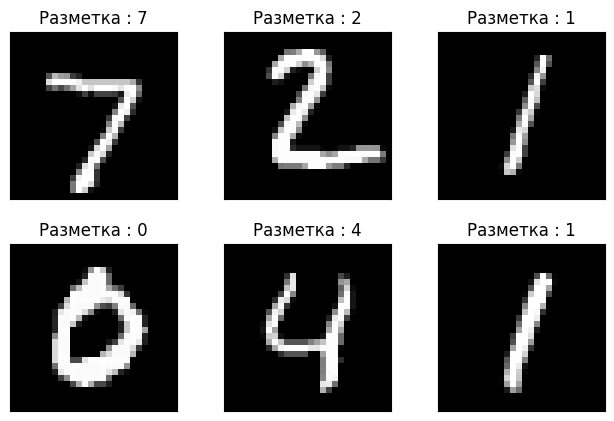

In [12]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1) # отрисуем 6 картинок
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray')
  plt.title(f"Разметка : {example_targets[i]}")
  plt.xticks([])
  plt.yticks([])
# fig

Ага, видим, что у каждой картинки есть своя метка, которую мы будем использовать при обучении.

Посмотрим на одну картинку более детально.

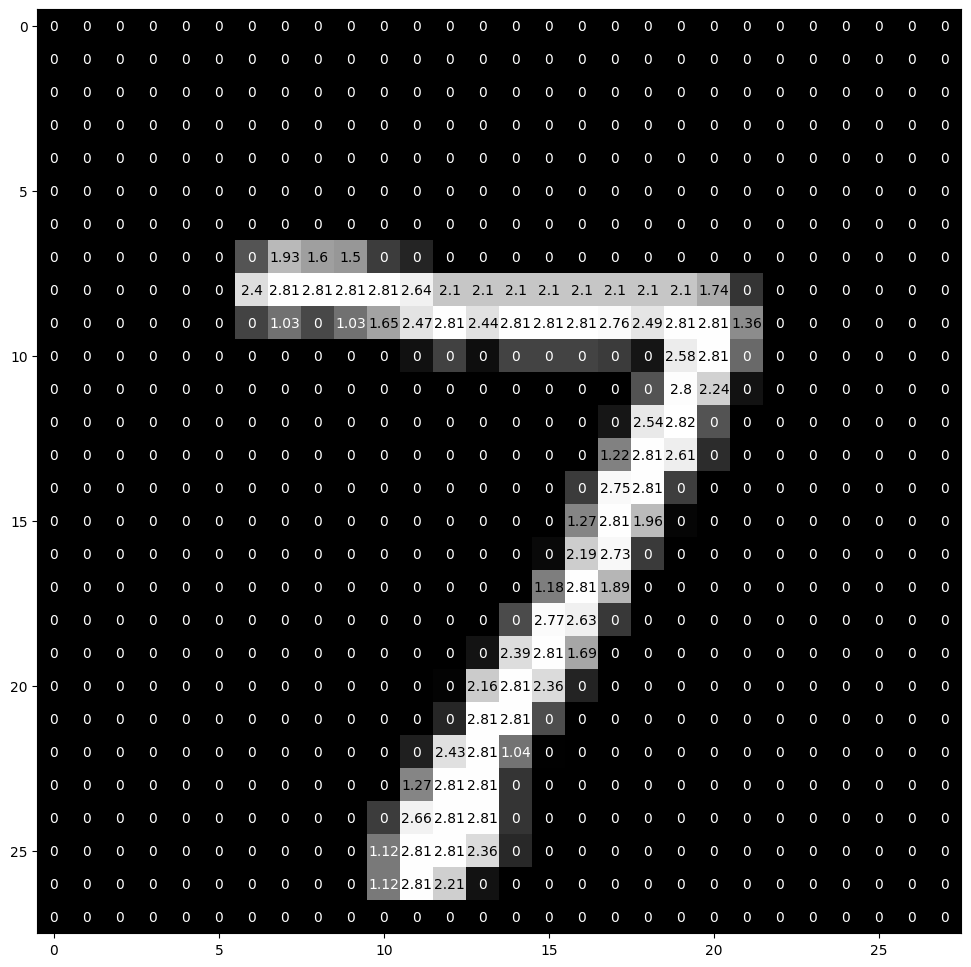

In [13]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.numpy()

img = np.squeeze(images[0])
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5 # установим порог
for x in range(width):
    for y in range(height):
        val = round(img[x][y], 2) if img[x][y] > 1 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

### Строим полносвязанную нейронную сеть

Построение нейронной сети в PyTorch одно удовольствие. Этот процесс напоминает построение детской пирамидки: нанизывание одного элемента за другим, причем каждый элемент строго на своем месте. 

Все функции активации, потерь и элементарные блоки уже реализованы в PyTorch. 

Например, один полносвязанный слой вызывается методом **nn.Linear**, которому передается количество нейронов на вход и на выход.

In [14]:
class MNIST_Net(nn.Module): # наследуемся от класса nn.Module
    def __init__(self):
        super(MNIST_Net, self).__init__()
        # количество нейронов в скрытых слоях (256, 128)
        hidden_1 = 256
        hidden_2 = 128
        # первый слой (784(=28*28) -> hidden_1)
        self.fc1 = nn.Linear(28*28, hidden_1) 
        # второй слой (hidden_1 -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # третий (выходной) слой (hidden_2 -> 10 (классов))
        self.fc3 = nn.Linear(hidden_2, 10)

        # self.flatten = nn.Flatten()
        # self.relu = nn.ReLU()
        
    def forward(self,x):
        # преобразуем батч картинок из (N, 28, 28) в (N, 784)
        x = x.view(-1, 28*28) # ИЛИ: x = self.flatten(x)
        # добавляем первый скрытый слой с ReLU активацией
        x = F.relu(self.fc1(x)) # ИЛИ: x = self.relu(self.fc1(x))
        # добавляем второй скрытый слой с ReLU активацией
        x = F.relu(self.fc2(x))
        # добавляем третий (выходной) слой
        x = self.fc3(x)
        # x = F.sigmoid(x)
        return x

Определяем модель

In [15]:
model = MNIST_Net()
model = model.cuda()
print(model) # посмотрим на нашу модель

MNIST_Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


Определяем функцию потерь и оптимизатор

In [16]:
# функция потерь (cross-entropy) для 10 классов
criterion = nn.CrossEntropyLoss()

# SGD (классический) со скоростью обучения (learning rate) = 0.001
optimizer = optim.SGD(model.parameters(), lr=CFG.lr)

In [17]:
# функция обучения модели
def train(model, device, train_loader, optimizer, criterion, epoch, WANDB):
    model.train() # обязательно переводим в режим обучения
    test_loss = 0
    correct = 0
    
    n_ex = len(train_loader)
    
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=n_ex):
        data, target = data.to(device), target.to(device) # переводим картинки и таргеты на GPU
        # обнуляем градиенты!
        optimizer.zero_grad()
        # прямой проход
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item() # определяем корректность предсказания
        train_loss = criterion(output, target) # считаем значение функции потерь
        # обратный проход
        train_loss.backward()
        # делаем градиентный шаг оптимизатором
        optimizer.step()
        # считаем метрики и лосс
    tqdm.write('\nTrain set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        train_loss, 100. * correct / len(train_loader.dataset)))
    
    if WANDB:
        wandb.log({'train_loss': train_loss,
                   'train_accuracy': correct / len(train_loader.dataset)})

In [18]:
# функция тестирования
def test(model, device, test_loader, criterion, WANDB):
    model.eval() # переводем модель в режим инференса
    test_loss = 0
    correct = 0
    # показываем, что обученич нет и градиенты не обновляются
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output, target) # считаем значение функции потерь
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # считаем метрики
    tqdm.write('Test set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        test_loss, 100. * correct / len(test_loader.dataset)))
    
    if WANDB:
        wandb.log({'test_loss': test_loss,
                   'test_accuracy': correct / len(test_loader.dataset)})

In [19]:
# основная функция для экспериментов
def main(model):
    # настраиваем окружение для wandb
    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, entity=CFG.entity, reinit=True, config=class2dict(CFG))
  
    use_cuda = torch.cuda.is_available()

    seed_everything(CFG.seed)

    device = torch.device("cuda" if use_cuda else "cpu")
    
    if CFG.wandb:
        wandb.watch(model, log='all') # логируем все (метрики, лоссы, градиенты)

    for epoch in range(1, CFG.num_epochs + 1): # цикл на эпохи
        print('\nEpoch:', epoch)
        train(model, device, train_loader, optimizer, criterion, epoch, CFG.wandb)
        test(model, device, test_loader, criterion, CFG.wandb)
    print('Training is end!')

Перед началом обучения обязательно проверяем состояние нашей видеокарты. 

In [29]:
gpu_info_1 = !nvidia-smi

print(gpu_info_1)

['Mon Nov 20 16:24:07 2023       ', '+-----------------------------------------------------------------------------+', '| NVIDIA-SMI 529.08       Driver Version: 529.08       CUDA Version: 12.0     |', '|-------------------------------+----------------------+----------------------+', '| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |', '| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |', '|                               |                      |               MIG M. |', '|===============================+======================+======================|', '|   0  NVIDIA GeForce ... WDDM  | 00000000:03:00.0 Off |                  N/A |', '| N/A   48C    P8     3W /  30W |   1856MiB /  2048MiB |      0%      Default |', '|                               |                      |                  N/A |', '+-------------------------------+----------------------+----------------------+', '                                                  

In [20]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Mon Nov 20 16:11:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 529.08       Driver Version: 529.08       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:03:00.0 Off |                  N/A |
| N/A   58C    P0    11W /  30W |   1886MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Учим!

In [21]:
main(model)


Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 938/938 [00:07<00:00, 131.24it/s]



Train set: Average loss: 2.0044, Accuracy: 46%
Test set: Average loss: 1.9900, Accuracy: 70%

Epoch: 2


100%|██████████| 938/938 [00:06<00:00, 156.09it/s]



Train set: Average loss: 1.1181, Accuracy: 73%
Test set: Average loss: 1.3240, Accuracy: 77%

Epoch: 3


100%|██████████| 938/938 [00:05<00:00, 160.17it/s]



Train set: Average loss: 0.7406, Accuracy: 80%
Test set: Average loss: 0.9303, Accuracy: 83%

Epoch: 4


100%|██████████| 938/938 [00:06<00:00, 145.83it/s]



Train set: Average loss: 0.9131, Accuracy: 84%
Test set: Average loss: 0.7720, Accuracy: 85%

Epoch: 5


100%|██████████| 938/938 [00:07<00:00, 117.29it/s]



Train set: Average loss: 0.3490, Accuracy: 86%
Test set: Average loss: 0.6898, Accuracy: 87%

Epoch: 6


100%|██████████| 938/938 [00:08<00:00, 116.78it/s]



Train set: Average loss: 0.4654, Accuracy: 87%
Test set: Average loss: 0.6433, Accuracy: 89%

Epoch: 7


100%|██████████| 938/938 [00:07<00:00, 121.89it/s]



Train set: Average loss: 0.3422, Accuracy: 88%
Test set: Average loss: 0.6063, Accuracy: 89%

Epoch: 8


100%|██████████| 938/938 [00:08<00:00, 105.80it/s]



Train set: Average loss: 0.2965, Accuracy: 89%
Test set: Average loss: 0.5891, Accuracy: 90%

Epoch: 9


100%|██████████| 938/938 [00:09<00:00, 99.10it/s] 



Train set: Average loss: 0.2523, Accuracy: 89%
Test set: Average loss: 0.5692, Accuracy: 90%

Epoch: 10


100%|██████████| 938/938 [00:08<00:00, 109.33it/s]



Train set: Average loss: 0.6583, Accuracy: 90%
Test set: Average loss: 0.5541, Accuracy: 90%
Training is end!


In [22]:
torch.save(model, 'mnist_model.pt') # сохранение модели обученной

In [23]:
model = torch.load('mnist_model.pt') # создание модели из сохраненной модели

In [24]:
model

MNIST_Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

Видим, что обучение идет: функция потерь падает, метрика растет. 

А что если взять более продвинутый оптимизатор? Например, Адам.

In [25]:
optimizer = optim.Adam(model.parameters(), lr=CFG.lr)

In [26]:
main(model)


Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 938/938 [00:08<00:00, 116.91it/s]



Train set: Average loss: 0.0958, Accuracy: 94%
Test set: Average loss: 0.2365, Accuracy: 97%

Epoch: 2


100%|██████████| 938/938 [00:08<00:00, 114.97it/s]



Train set: Average loss: 0.1666, Accuracy: 97%
Test set: Average loss: 0.0985, Accuracy: 97%

Epoch: 3


100%|██████████| 938/938 [00:08<00:00, 112.40it/s]



Train set: Average loss: 0.0506, Accuracy: 98%
Test set: Average loss: 0.1297, Accuracy: 98%

Epoch: 4


100%|██████████| 938/938 [00:10<00:00, 93.10it/s] 



Train set: Average loss: 0.0493, Accuracy: 98%
Test set: Average loss: 0.1163, Accuracy: 98%

Epoch: 5


100%|██████████| 938/938 [00:10<00:00, 87.01it/s] 



Train set: Average loss: 0.0013, Accuracy: 99%
Test set: Average loss: 0.1898, Accuracy: 97%

Epoch: 6


100%|██████████| 938/938 [00:11<00:00, 83.64it/s] 



Train set: Average loss: 0.0037, Accuracy: 99%
Test set: Average loss: 0.1013, Accuracy: 98%

Epoch: 7


100%|██████████| 938/938 [00:10<00:00, 92.46it/s] 



Train set: Average loss: 0.0286, Accuracy: 99%
Test set: Average loss: 0.1506, Accuracy: 98%

Epoch: 8


100%|██████████| 938/938 [00:08<00:00, 104.99it/s]



Train set: Average loss: 0.0031, Accuracy: 99%
Test set: Average loss: 0.1079, Accuracy: 98%

Epoch: 9


100%|██████████| 938/938 [00:10<00:00, 88.38it/s] 



Train set: Average loss: 0.1770, Accuracy: 99%
Test set: Average loss: 0.1888, Accuracy: 97%

Epoch: 10


100%|██████████| 938/938 [00:08<00:00, 105.28it/s]



Train set: Average loss: 0.1553, Accuracy: 99%
Test set: Average loss: 0.1418, Accuracy: 98%
Training is end!


Сразу видим, что обучение пошло гораздо быстрее и значение метрики выше. Не обманула математика!

В PyTorch полносвязанную сеть можно создать с помощью готового метода Sequential(). По сути это уже готовый каркас, куда можно вставить слои и активации, в итоге нам не нужно в forward прописывать каждый слой отдельно, все работает в автоматическом режиме. Красота!

In [35]:
class MNIST_Net(nn.Module): # наследуемся от класса nn.Module
    def __init__(self):
        super(MNIST_Net,self).__init__()
        # организуем 3 скрытых слоя
        hidden_1 = 256
        hidden_2 = 128
        hidden_3 = 64
        # 
        self.net = torch.nn.Sequential(
                      torch.nn.Linear(28*28, hidden_1),
                      torch.nn.ReLU(),
                      torch.nn.Linear(hidden_1, hidden_2),
                      torch.nn.ReLU(),
                      torch.nn.Linear(hidden_2, hidden_3),
                      torch.nn.ReLU(),
                      torch.nn.Linear(hidden_3, 10),
                      torch.nn.Softmax()
                    )
        
    def forward(self,x):
        # преобразуем батч картинок из (N, 28, 28) в (N, 784)
        x = x.view(-1,28*28)
        x = self.net(x)
        return x

In [36]:
model = MNIST_Net()
model = model.cuda() # переводим модель GPU
print(model) # посмотрим на нашу модель

MNIST_Net(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
    (7): Softmax(dim=None)
  )
)


Проверим, что все работает. 

In [37]:
main(model)


Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]

c:\Users\k-pro\OneDrive\Desktop\k-project\.venv\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 938/938 [00:05<00:00, 168.59it/s]



Train set: Average loss: 2.3035, Accuracy: 8%
Test set: Average loss: 2.3026, Accuracy: 8%

Epoch: 2


100%|██████████| 938/938 [00:05<00:00, 177.40it/s]



Train set: Average loss: 2.3059, Accuracy: 8%
Test set: Average loss: 2.3026, Accuracy: 8%

Epoch: 3


100%|██████████| 938/938 [00:05<00:00, 185.77it/s]



Train set: Average loss: 2.3028, Accuracy: 8%
Test set: Average loss: 2.3026, Accuracy: 8%

Epoch: 4


100%|██████████| 938/938 [00:05<00:00, 173.33it/s]



Train set: Average loss: 2.3042, Accuracy: 8%
Test set: Average loss: 2.3026, Accuracy: 8%

Epoch: 5


100%|██████████| 938/938 [00:05<00:00, 169.93it/s]



Train set: Average loss: 2.3016, Accuracy: 8%
Test set: Average loss: 2.3026, Accuracy: 8%

Epoch: 6


100%|██████████| 938/938 [00:05<00:00, 169.14it/s]



Train set: Average loss: 2.3041, Accuracy: 8%
Test set: Average loss: 2.3026, Accuracy: 8%

Epoch: 7


100%|██████████| 938/938 [00:05<00:00, 161.82it/s]



Train set: Average loss: 2.3039, Accuracy: 8%
Test set: Average loss: 2.3026, Accuracy: 8%

Epoch: 8


100%|██████████| 938/938 [00:05<00:00, 162.80it/s]



Train set: Average loss: 2.3026, Accuracy: 8%
Test set: Average loss: 2.3026, Accuracy: 8%

Epoch: 9


100%|██████████| 938/938 [00:05<00:00, 161.53it/s]



Train set: Average loss: 2.3020, Accuracy: 8%
Test set: Average loss: 2.3026, Accuracy: 8%

Epoch: 10


100%|██████████| 938/938 [00:05<00:00, 162.25it/s]



Train set: Average loss: 2.3040, Accuracy: 8%
Test set: Average loss: 2.3026, Accuracy: 8%
Training is end!


Итак, мы наглядно показали - даже небольшая полносвязанная сеть способна уже решать нетривиалные задачи и решать их крайне успешно. 